<a href="https://colab.research.google.com/github/JuhiRaj/3DSimulations/blob/main/LaUNET2D221_Spheres_SPV_Final_17_10_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model


In [ ]:
from IPython.core.display import Image
import torch
import torch.nn as nn
from torchsummary import summary


def double_conv(in_c, out_c):
  conv = nn.Sequential(
      nn.Conv2d(in_c, out_c, kernel_size=3, padding="same"),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_c, out_c, kernel_size=3, padding="same"),
      nn.ReLU(inplace=True),
  )
  return conv

def double_conv_up(in_c, out_c):
  conv = nn.Sequential(
      nn.Conv2d(in_c, out_c, kernel_size=3, padding="same"),
      nn.ReLU(inplace=True),
      nn.Conv2d(out_c, out_c, kernel_size=3, padding="same"),
      nn.ReLU(inplace=True),
  )
  return conv



def crop_img(tensor, target_tensor):
  target_size = target_tensor.size()[2]
  if tensor.size()[2] % 2 == 1:
    tensor_size = tensor.size()[2]-1
  else:
    tensor_size = tensor.size()[2]
  delta = tensor_size - target_size
  delta = delta // 2
  return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]


class UNet(nn.Module):
  def __init__(self):
    super(UNet, self).__init__()
    self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.down_conv_1 = double_conv(1,64)
    self.down_conv_2 = double_conv(64,128)
    self.down_conv_3 = double_conv(128,256)
    self.down_conv_4 = double_conv(256,512)
    self.down_conv_5 = double_conv(512,1024)

 
    self.up_trans_1 = nn.ConvTranspose2d(in_channels=1024,
                                         out_channels=512, 
                                         kernel_size=2,
                                         stride=2,
                                         output_padding=1)

    self.up_conv_1 = double_conv_up(1024, 512)



    self.up_trans_2 = nn.ConvTranspose2d(in_channels=512,
                                         out_channels=256, 
                                         kernel_size=2,
                                         stride=2,
                                         output_padding=1)

    self.up_conv_2 = double_conv_up(512, 256)




    self.up_trans_3 = nn.ConvTranspose2d(in_channels=256,
                                         out_channels=128, 
                                         kernel_size=2,
                                         stride=2)

    self.up_conv_3 = double_conv_up(256, 128)



    self.up_trans_4 = nn.ConvTranspose2d(in_channels=128,
                                         out_channels=64, 
                                         kernel_size=2,
                                         stride=2,
                                         output_padding=1)

    self.up_conv_4 = double_conv_up(128, 64)

    self.out = nn.Conv2d(
        in_channels=64,
        out_channels=1,
        kernel_size=1,
        stride=1
    )




  def forward(self, image):
    # bs, c, h, w
    #encoder
    maxx = torch.max(image)
    x1 = self.down_conv_1(image/maxx) #A1
    x2 = self.max_pool_2x2(x1) #A2

    x3 = self.down_conv_2(x2) #B1
    x4 = self.max_pool_2x2(x3) #B2

    x5 = self.down_conv_3(x4) #C1
    x6 = self.max_pool_2x2(x5) #C2

    x7 = self.down_conv_4(x6) #D1
    x8 = self.max_pool_2x2(x7) #D2 

    #print('Bottle Neck')
    x9 = self.down_conv_5(x8) #E1 (Neck of the UNet)
 

    #decoder
    x10 = self.up_trans_1(x9) 
    c1_cat = torch.cat([x10, x7], 1)

    x11 = self.up_conv_1(c1_cat)
    x12 = self.up_trans_2(x11)
    c2_cat = torch.cat([x12, x5], 1)

    x13 = self.up_conv_2(c2_cat)
    x14 = self.up_trans_3(x13)
    c3_cat = torch.cat([x14, x3], 1)

    x15 = self.up_conv_3(c3_cat)
    x16 = self.up_trans_4(x15)
    c4_cat = torch.cat([x16, x1], 1)

    x17 = self.up_conv_4(c4_cat)
    x18 = self.out(x17)*maxx
    return x18 + image 


if __name__ == "__main__":
  image = torch.rand((1,1,221,221))
  model = UNet()
  print('1',model(image).shape)
  #print(model)


from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)


1 torch.Size([1, 1, 221, 221])
+----------------------+------------+
|       Modules        | Parameters |
+----------------------+------------+
| down_conv_1.0.weight |    576     |
|  down_conv_1.0.bias  |     64     |
| down_conv_1.2.weight |   36864    |
|  down_conv_1.2.bias  |     64     |
| down_conv_2.0.weight |   73728    |
|  down_conv_2.0.bias  |    128     |
| down_conv_2.2.weight |   147456   |
|  down_conv_2.2.bias  |    128     |
| down_conv_3.0.weight |   294912   |
|  down_conv_3.0.bias  |    256     |
| down_conv_3.2.weight |   589824   |
|  down_conv_3.2.bias  |    256     |
| down_conv_4.0.weight |  1179648   |
|  down_conv_4.0.bias  |    512     |
| down_conv_4.2.weight |  2359296   |
|  down_conv_4.2.bias  |    512     |
| down_conv_5.0.weight |  4718592   |
|  down_conv_5.0.bias  |    1024    |
| down_conv_5.2.weight |  9437184   |
|  down_conv_5.2.bias  |    1024    |
|  up_trans_1.weight   |  2097152   |
|   up_trans_1.bias    |    512     |
|  up_conv_1.0.weig

31030593

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
import cv2
import random
from google.colab import drive
drive.mount('/content/gdrive/')

path_kernel = "/content/gdrive/MyDrive/Figures/Sphere/"

train_img_dir ="/content/gdrive/MyDrive/PSF_Sphere_Train/image/"
train_label_dir ="/content/gdrive/MyDrive/PSF_Sphere_Train/label/"
validate_img_dir ="/content/gdrive/MyDrive/PSF_Sphere_Train/image/"
validate_label_dir ="/content/gdrive/MyDrive/PSF_Sphere_Train/label/"
test_img_dir ="/content/gdrive/MyDrive/PSF_Sphere_Train/image/"
test_label_dir ="/content/gdrive/MyDrive/PSF_Sphere_Train/label/"


train_img_list = os.listdir(train_img_dir)
train_img_list.sort() #very important to sort in order to match both the images and labels
train_msk_list = os.listdir(train_label_dir)
train_msk_list.sort()

validate_img_list = os.listdir(validate_img_dir)
validate_img_list.sort() #very important to sort in order to match both the images and labels
validate_msk_list = os.listdir(validate_label_dir)
validate_msk_list.sort()

test_img_list = os.listdir(test_img_dir)
test_img_list.sort() #very important to sort in order to match both the images and labels
test_msk_list = os.listdir(test_label_dir)
test_msk_list.sort()


num_images_train = len(os.listdir(train_img_dir))
num_images_validate = len(os.listdir(validate_img_dir))
num_images_test = len(os.listdir(test_img_dir))

print("Total number of training images are:", num_images_train)
print("Total number of validating images are:", num_images_validate)
print("Total number of testing images are:", num_images_test)



Mounted at /content/gdrive/


FileNotFoundError: ignored

In [ ]:
img_num_train = random.randint(0, num_images_train-1)
print(img_num_train)
img_for_plot =cv2.imread(train_img_dir+train_img_list[img_num_train], 0)
label_for_plot =cv2.imread(train_label_dir+train_img_list[img_num_train], 0)

plt.figure(figsize=(6,4))
plt.subplot(121)
plt.imshow(img_for_plot, cmap='gray', extent=[-110.5, 110.5, -110.5, 110.5])
plt.title('Train Image')
plt.subplot(122)
plt.imshow(label_for_plot, cmap='gray', extent=[-110.5, 110.5, -110.5, 110.5])
plt.title('Train Label')
plt.show()
plt.savefig(path_kernel + str(1)+'.png')


loss_fn = torch.nn.CrossEntropyLoss()
img=cv2.imread("/content/gdrive/MyDrive/PSF_Sphere_Train/image/5.png")
print(img.shape)

NameError: ignored

494


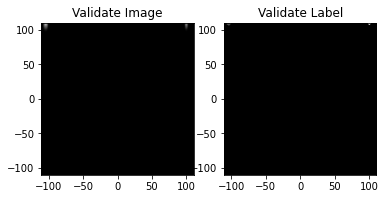

In [ ]:
img_num_validate = random.randint(0, num_images_validate-1)
print(img_num_validate)
img_for_plot =cv2.imread(train_img_dir+train_img_list[img_num_validate], 0)
label_for_plot =cv2.imread(train_label_dir+train_img_list[img_num_validate], 0)

plt.figure(figsize=(6,4))
plt.subplot(121)
plt.imshow(img_for_plot, cmap='gray', extent=[-110.5, 110.5, -110.5, 110.5])
plt.title('Validate Image')
plt.subplot(122)
plt.imshow(label_for_plot, cmap='gray', extent=[-110.5, 110.5, -110.5, 110.5])
plt.title('Validate Label')
plt.show()

In [ ]:
print("Unique values in the label are:", np.unique(label_for_plot))
print("Unique values in the image are:", np.unique(img_for_plot))

Unique values in the label are: [ 30  91 215]
Unique values in the image are: [ 30  31  32  33  34  35  36  38  40  41  42  43  44  46  47  48  50  51
  53  55  56  58  60  61  63  64  67  69  70  72  76  78  82  84  85  88
  89  90  92  94  95  97 100 104 107 108 109 110 113 115 117 120 122 124
 127 132 133 135 140 141 142 147 149 157 166 167 182 215]


# Data Loader

In [ ]:
import glob
import os
import random
import cv2
import torch
from torch.utils.data import Dataset
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive/')



class Data_Loader(Dataset):
  def __init__(self, data_path):
        self.data_path = data_path
        self.imgs_path = glob.glob(os.path.join(data_path, 'image/*.png'))
        #print(self.imgs_path)
        self.imgs_path.sort()
        self.labs_path = glob.glob(os.path.join(data_path, 'label/*.png'))
        #print(self.labs_path)
        self.labs_path.sort()

  def __len__(self):
        return len(self.imgs_path)

  def __getitem__(self, index):
        image_path = self.imgs_path[index]
        label_path = self.labs_path[index]
        image = cv2.imread(image_path)
        label = cv2.imread(label_path)
        #print(image.shape)
        #print(label.shape)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        image = image.reshape(1, image.shape[0], image.shape[1])
        label = label.reshape(1, label.shape[0], label.shape[1])
        #print(label.max())
        """if label.max() > 1:
            label = label / 255
        if image.max() > 1:
            image = image / 255"""
        return image, label



if __name__ == "__main__":
  train_dataset = Data_Loader("/content/gdrive/MyDrive/PSF_Sphere_Train/")
  print("length：", len(train_dataset))
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=20,
                                               shuffle=True)
  print(len(train_loader))
  #for image, label in train_loader:
    #print(image.shape)
    #print(label.shape)


Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
length： 500
25


In [ ]:
import torch
print(torch.cuda.is_available())

True


#Train

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

#from utils import(
#    load_checkpoint,
#    save_checkpoint,
#    get_loaders,
#    check_accuracy,
#    save_predictions_as_imgs,
#)


#Hyperparameters etc.
LEARNING_RATE = 0.0001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 20
NUM_EPOCHS = 100
NUM_WORKERS = 2
IMAGE_HEIGHT = 221
IMAGE_WIDTH = 221
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = train_img_dir
TRAIN_MASK_DIR = train_label_dir
VAL_IMG_DIR = validate_img_dir
VAL_MASK_DIR = validate_label_dir



def train_fn(loader, model, optimizer, loss_fn):
  loop = tqdm(loader)
  
  #for batch_idx, (data, targets) in enumerate(loop):
  for _ in range(NUM_EPOCHS):
    #print('epoch = ', _)
    for data, targets in loader:
      data = data.to(device=DEVICE, dtype = torch.float32)
      targets = targets.to(device=DEVICE, dtype = torch.float32)
      #print(data.shape, targets.shape)
      #return
      #forward 
      #with torch.cuda.amp.autocast():
      predictions = model(data)
      loss = loss_fn(predictions, targets)

      #backward
      #optimizer.zero_grad()
      #scaler.scale(loss).backward()
      #scaler.step(optimizer)
      #scaler.update()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      print(loss.item())
      #if loss.item() < 10:
      #  plt.imshow(predictions[0,0].cpu().detach().numpy())
      #  plt.show()
      #  input()

      #update tqdm loop
      #loop.set_postfix(loss=loss.item())
  


def main():
  train_transform = A.Compose(
      [
          A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          #A.Rotate(limit=35, p =1.0),
          #A.HorizontalFlip(p=0.5),
          #A.VerticalFlip(p=0.1),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
       ]
  )


  val_transforms = A.Compose(
      [
          A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
       ]
  )

  model = UNet().to(device=DEVICE)
  loss_fn = nn.L1Loss()
  optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


  train_dataset = Data_Loader("/content/gdrive/MyDrive/PSF_Sphere_Train/")
  print("length：", len(train_dataset))
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=20,
                                               shuffle=True)

  train_fn(train_loader, model, optimizer, loss_fn)
  #model.save("Model_dict")
  #for image, label in train_loader:
    #plt.imshow(image[0,0])
    #plt.show()




  #scaler = torch.cuda.amp.GradScaler()
  torch.save(model.state_dict(), '/content/gdrive/MyDrive/Model_PSFSphere_Train')


if __name__ == "__main__":
  main()



length： 500


  0%|          | 0/25 [00:00<?, ?it/s]

1.1651911735534668
1.452829360961914
1.329237699508667
0.7682798504829407
1.0097376108169556
1.1668452024459839
1.0647510290145874
0.5489198565483093
0.8491186499595642
0.7488749027252197
0.7520496845245361
0.6179167628288269
0.7939452528953552
0.7387143969535828
0.8242607712745667
0.7048041224479675
0.5838740468025208
0.6863401532173157
0.6046943068504333
0.6172599196434021
0.6782717704772949
0.609824001789093
0.86527019739151
0.5243239998817444
0.6658809781074524
0.6926608681678772
0.6987448930740356
0.6190884709358215
0.7049053311347961
0.5441864132881165
0.6073594093322754
0.5814249515533447
0.6221681237220764
0.515242338180542
0.6962499618530273
0.6283392310142517
0.652428150177002
0.546890914440155
0.6275658011436462
0.5780493021011353
0.6446550488471985
0.6293219923973083
0.6101480722427368
0.6852688193321228
0.6478696465492249
0.5796920657157898
0.5541132092475891
0.6416696906089783
0.7430064082145691
0.639468789100647
0.5576720237731934
0.5747073888778687
0.6069338321685791
0.

  0%|          | 0/25 [43:44<?, ?it/s]

0.04547679424285889


In [ ]:
from matplotlib import pyplot as plt
from skimage.measure import profile_line
from skimage.io import imread

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm


valid_dataset = Data_Loader("/content/gdrive/MyDrive/PSF_Sphere_Eval/")
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset,
                                               batch_size=1,
                                               shuffle=False)
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Model_PSFSphere_Train'))
model.eval()


path_output = "/content/gdrive/MyDrive/PSF_Sphere_Eval/output/"
os.mkdir(path_output)

i=0
for data, label in valid_loader:
  print(i)
  fig, ax = plt.subplots(2, 3, figsize=(10, 10)) #Create the figures
  ax[0, 0].imshow(label[0][0],extent=[-110.5, 110.5, -110.5, 110.5])
  ax[0, 0].set_title('Label Image')

  ax[0, 1].imshow(data[0][0],extent=[-110.5, 110.5, -110.5, 110.5])
  ax[0, 1].set_title('Blurred Image')

  pred = model(data.to(dtype = torch.float32))
  ax[0, 2].imshow(pred[0,0].detach().numpy(), extent=[-110.5, 110.5, -110.5, 110.5])
  ax[0, 2].set_title('Network Predicted Image')

  ax[1, 0].imshow(data[0][0]- np.array(label[0][0]), extent=[-110.5, 110.5, -110.5, 110.5])
  ax[1, 0].set_title('Blurred - Label')

  ax[1, 1].imshow(pred[0,0].detach().numpy() - np.array(label[0][0]), extent=[-110.5, 110.5, -110.5, 110.5])
  ax[1, 1].set_title('Network Predicted - Label ')

  diff_NP = (pred[0,0].detach().numpy()) - (np.array(label[0][0]))
  ax[1, 2].imshow((np.array(label[0][0])-diff_NP), extent=[-110.5, 110.5, -110.5, 110.5])
  ax[1, 2].set_title('Label - diff(Network Pred)')

  plt.imsave(path_output + str(i)+'.png', pred[0,0].detach().numpy())
  i=i+1


"""

  start = (0., 110.5) #Start of the profile line
  end = (221., 110.5) #End of the profile line
  profile_label = profile_line(label[0][0], start, end, linewidth=2) #Take the profile line
  profile_image = profile_line(data[0][0], start, end, linewidth=2) #Take the profile line
  profile_network = profile_line(pred[0,0].detach().numpy(), start, end, linewidth=2) #Take the profile line
  plt.figure('Intensity profile')
  plt.plot(profile_label, 'b', profile_image, 'g', profile_network, 'r')
  plt.draw()

i=0
for data, label in valid_loader:
  print(data)
  plt.imshow(data[0][0],extent=[-110.5, 110.5, -110.5, 110.5])
  plt.title('Blurred Image')
  plt.show()


  plt.imshow(data[0][0]- np.array(label[0][0]), extent=[-110.5, 110.5, -110.5, 110.5])
  plt.title('Blurred Image - Label')
  plt.show()
 
  plt.imshow(label[0][0], extent=[-110.5, 110.5, -110.5, 110.5])
  plt.title('Label')
  plt.show()
 
  pred = model(data.to(dtype = torch.float32))
  plt.imshow(pred[0,0].detach().numpy(), extent=[-110.5, 110.5, -110.5, 110.5])
  plt.title('Network Predicted')
  plt.show()
  plt.imsave(path_output + str(i)+'.png', pred)
  i=i+1

  plt.imshow(pred[0,0].detach().numpy()- np.array(label[0][0]), extent=[-110.5, 110.5, -110.5, 110.5])
  plt.title('Network Predicted - Label')
  plt.show()

  #input()

"""

FileExistsError: ignored

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: FutureWarning: Default out of bounds interpolation mode 'constant' is deprecated. In version 0.19 it will be set to 'reflect'. To avoid this warning, set `mode=` explicitly.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: FutureWarning: Default out of bounds interpolation mode 'constant' is deprecated. In version 0.19 it will be set to 'reflect'. To avoid this warning, set `mode=` explicitly.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: FutureWarning: Default out of bounds interpolation mode 'constant' is deprecated. In version 0.19 it will be set to 'reflect'. To avoid this warning, set `mode=` explicitly.


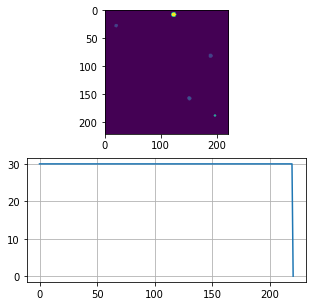

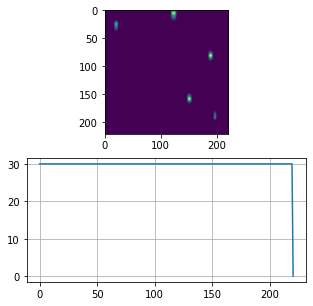

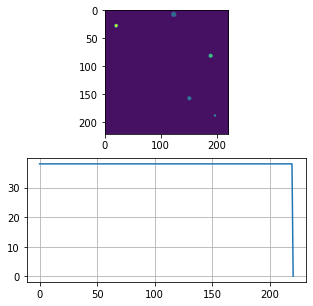

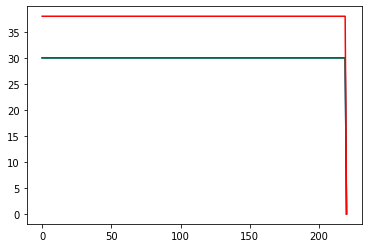

In [ ]:
from matplotlib import pyplot as plt
from skimage.measure import profile_line
from skimage.io import imread

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cbook as cbook
from matplotlib import cm
 
 
 
validate_img_dir ="/content/gdrive/MyDrive/PSF_Sphere_Eval/image/"
validate_label_dir ="/content/gdrive/MyDrive/PSF_Sphere_Eval/label/"
validate_output_dir ="/content/gdrive/MyDrive/PSF_Sphere_Eval/output/"

validate_img_list = os.listdir(validate_img_dir)
validate_img_list.sort() #very important to sort in order to match both the images and labels
validate_msk_list = os.listdir(validate_label_dir)
validate_msk_list.sort()
validate_output_list = os.listdir(validate_output_dir)
validate_output_list.sort()

start = (1, 221) #Start of the profile line
end = (-100, 100) #End of the profile line

img_for_plot =cv2.imread(validate_img_dir+validate_img_list[1], 0)
label_for_plot =cv2.imread(validate_label_dir+validate_msk_list[1], 0)
output_for_plot =cv2.imread(validate_output_dir+validate_output_list[1], 0)

#plt.plot(start, end, color="red", linewidth=2)
#plt.imshow(img_for_plot)

#profile_label = profile_line(img_for_plot, start, end, linewidth=2) #Take the profile line
#profile_image = profile_line(label_for_plot, start, end, linewidth=2) #Take the profile line
#profile_network = profile_line(output_for_plot, start, end, linewidth=2) #Take the profile line

#plt.figure('Intensity profile')
#plt.plot(profile_label, 'b', profile_image, 'g', profile_network, 'r')
#plt.draw()

start = (1, 50) #Start of the profile line
end = (221, 50) #End of the profile line
profile_label = profile_line(label_for_plot, start, end, linewidth=2) #Take the profile line
fig, ax = plt.subplots(2, 1, figsize=(5, 5)) #Create the figures
ax[0].imshow(label_for_plot) #Show the film at the top
ax[1].plot(profile_label)
ax[1].grid()


profile_image = profile_line(img_for_plot, start, end, linewidth=2) #Take the profile line
fig, ax = plt.subplots(2, 1, figsize=(5, 5)) #Create the figures
ax[0].imshow(img_for_plot) #Show the film at the top
ax[1].plot(profile_image)
ax[1].grid()


profile_network = profile_line(output_for_plot, start, end, linewidth=2) #Take the profile line
fig, ax = plt.subplots(2, 1, figsize=(5, 5)) #Create the figures
ax[0].imshow(output_for_plot) #Show the film at the top
ax[1].plot(profile_network)
ax[1].grid()


plt.figure('Intensity profile')
plt.plot(profile_label, 'b', profile_image, 'g', profile_network, 'r')
plt.draw()
